### Objective
The goal of using GAN is to solve the problem of overfitting the CL classification due to possible duplicate images due to larger number of bootstrap iterations. Therefore, the current data generation process will involve both bootstrapp sampling followed by GAN. Half of the required dataset will be generated using bootstrap method and the rest will generated through GAN from this data


## Description
GAN refers to the " Generative Adversarial network". It is used to generate fake images as close as possible to the real images. GAN consists of two competing convolutional neural networks, Discriminator and Generator. Discrimator takes fake and real images as input and tries to disciminate them. Generator network generates fake images as close as possible to the real images to fool the discriminator. Therefore, by using the feedback from discriminator, generator updates its weights to produce more images as close as possible to the real images.

## Implementation
The following implementation shows a step by stemp implementation of GAN. This is a modified version of core from https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/. The original was trained to generate fake images from MNIST dataset. I modified it to generate sample topomap images.

### 1. Define a standalone disciminator network
Discriminator (D) network takes images from real and fake datastets( from generator) and tries to discriminate them. Unlike normal CNN, D does not have softmax layer, instead it used sigmoid activation function to return the probability of images being real. Therefore,the output should be close to 1 for real images and zero for fake images.

In [69]:
import tensorflow as tf
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
# define the standalone discriminator model
def define_discriminator(in_shape=(224,224,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


### 2.  Standalone generator model
The generator model is responsible for creating new fake but plausible topomap images. To do so, G takes point from latent space 

In [70]:

def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 14 * 14
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((14, 14,128)))
    
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
  
  # upsample to 56x56
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
#     model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    
     # upsample to 112x112
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    
     # upsample to 224x224
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (7,7), activation='sigmoid', padding='same'))
    return model


In [71]:
gen=define_generator(100)
print(gen.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 25088)             2533888   
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 25088)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 56, 56, 128)       262272    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 56, 56, 128)      

### 3. define the combined generator and discriminator model, for updating the generator
Here we stack together our to models. The discriminato model is trained in standalone fashion since its main role to classfify two images. So in the composite models, its weight will be frozen to classify the input image from G. The weights of G will be updated based on the results from D

In [72]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


### 4. Let's prepare our real and fake images

In [73]:
n_samples=500
path= "/home/kashraf/Research_2021/GAN_topomap/GAN_samples//"


filenames=os.listdir(path)
img_shape=(224,224)
data=np.array([cv2.resize(cv2.imread(path+file)/255.0,img_shape) for file in filenames])
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_topos_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()



In [74]:
data.shape

(500, 224, 224, 3)

### 5. Evaluate the Discriminator model

In [75]:
# import tqdm
# for k in range(tqdm (10)):
#     print(k)

In [76]:
import tqdm

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=500):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset,n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real topomap: %.0f%%, Accuracy fake topomaps: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)
 
   ##train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=32):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        print("-------------------CURRENT EPOCH-----------:",i+1)
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            print("------------EPOCH:{} BATCH :{}/{}--------------".format(i+1,j+1,bat_per_epo))
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('Discriminator Loss: {}\nGenerator Loss: {}\n'. format(d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % n_epochs == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
 


In [77]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# # load image data
dataset = data
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

-------------------CURRENT EPOCH-----------: 1
------------EPOCH:1 BATCH :1/15--------------
Discriminator Loss: 0.7242475152015686
Generator Loss: 0.27837225794792175

------------EPOCH:1 BATCH :2/15--------------
Discriminator Loss: 0.7898894548416138
Generator Loss: 0.5381346344947815

------------EPOCH:1 BATCH :3/15--------------
Discriminator Loss: 0.6194545030593872
Generator Loss: 0.7371681928634644

------------EPOCH:1 BATCH :4/15--------------
Discriminator Loss: 0.6579102277755737
Generator Loss: 0.6087875366210938

------------EPOCH:1 BATCH :5/15--------------
Discriminator Loss: 0.5829698443412781
Generator Loss: 0.5568183660507202

------------EPOCH:1 BATCH :6/15--------------
Discriminator Loss: 0.5806117057800293
Generator Loss: 0.6004288196563721

------------EPOCH:1 BATCH :7/15--------------
Discriminator Loss: 0.5689257979393005
Generator Loss: 0.6921592950820923

------------EPOCH:1 BATCH :8/15--------------
Discriminator Loss: 0.5082079172134399
Generator Loss: 0.75

Discriminator Loss: 0.5881125926971436
Generator Loss: 0.6479934453964233

------------EPOCH:5 BATCH :8/15--------------
Discriminator Loss: 0.4183256924152374
Generator Loss: 1.6130454540252686

------------EPOCH:5 BATCH :9/15--------------
Discriminator Loss: 0.40031081438064575
Generator Loss: 1.113916039466858

------------EPOCH:5 BATCH :10/15--------------
Discriminator Loss: 0.3052242398262024
Generator Loss: 0.9611490964889526

------------EPOCH:5 BATCH :11/15--------------
Discriminator Loss: 0.3525146245956421
Generator Loss: 1.2327666282653809

------------EPOCH:5 BATCH :12/15--------------
Discriminator Loss: 0.35878273844718933
Generator Loss: 1.2250112295150757

------------EPOCH:5 BATCH :13/15--------------
Discriminator Loss: 0.35205143690109253
Generator Loss: 1.1118550300598145

------------EPOCH:5 BATCH :14/15--------------
Discriminator Loss: 0.352515310049057
Generator Loss: 1.2886748313903809

------------EPOCH:5 BATCH :15/15--------------
Discriminator Loss: 0.338

Discriminator Loss: 0.6644273996353149
Generator Loss: 0.2708946764469147

------------EPOCH:9 BATCH :14/15--------------
Discriminator Loss: 0.9169270992279053
Generator Loss: 2.8339009284973145

------------EPOCH:9 BATCH :15/15--------------
Discriminator Loss: 0.24433736503124237
Generator Loss: 2.3741166591644287

-------------------CURRENT EPOCH-----------: 10
------------EPOCH:10 BATCH :1/15--------------
Discriminator Loss: 0.19088326394557953
Generator Loss: 1.2453991174697876

------------EPOCH:10 BATCH :2/15--------------
Discriminator Loss: 0.22243845462799072
Generator Loss: 2.1856064796447754

------------EPOCH:10 BATCH :3/15--------------
Discriminator Loss: 0.2022094428539276
Generator Loss: 2.2873010635375977

------------EPOCH:10 BATCH :4/15--------------
Discriminator Loss: 0.20135176181793213
Generator Loss: 1.2752701044082642

------------EPOCH:10 BATCH :5/15--------------
Discriminator Loss: 0.25582656264305115
Generator Loss: 2.8584766387939453

------------EPOCH:

Discriminator Loss: 0.11182096600532532
Generator Loss: 2.1589713096618652

------------EPOCH:14 BATCH :4/15--------------
Discriminator Loss: 0.11591126024723053
Generator Loss: 2.9694581031799316

------------EPOCH:14 BATCH :5/15--------------
Discriminator Loss: 0.12447186559438705
Generator Loss: 2.143144369125366

------------EPOCH:14 BATCH :6/15--------------
Discriminator Loss: 0.12714380025863647
Generator Loss: 2.5657005310058594

------------EPOCH:14 BATCH :7/15--------------
Discriminator Loss: 0.13120073080062866
Generator Loss: 1.9061195850372314

------------EPOCH:14 BATCH :8/15--------------
Discriminator Loss: 0.13140125572681427
Generator Loss: 2.8539199829101562

------------EPOCH:14 BATCH :9/15--------------
Discriminator Loss: 0.12854938209056854
Generator Loss: 2.1570217609405518

------------EPOCH:14 BATCH :10/15--------------
Discriminator Loss: 0.13074778020381927
Generator Loss: 2.791684865951538

------------EPOCH:14 BATCH :11/15--------------
Discriminator Lo

Discriminator Loss: 0.1128544732928276
Generator Loss: 2.5924906730651855

------------EPOCH:18 BATCH :10/15--------------
Discriminator Loss: 0.08266478776931763
Generator Loss: 2.658115863800049

------------EPOCH:18 BATCH :11/15--------------
Discriminator Loss: 0.06272326409816742
Generator Loss: 3.3525447845458984

------------EPOCH:18 BATCH :12/15--------------
Discriminator Loss: 0.07419700175523758
Generator Loss: 2.82423996925354

------------EPOCH:18 BATCH :13/15--------------
Discriminator Loss: 0.08958283066749573
Generator Loss: 3.780649423599243

------------EPOCH:18 BATCH :14/15--------------
Discriminator Loss: 0.10153372585773468
Generator Loss: 2.2474255561828613

------------EPOCH:18 BATCH :15/15--------------
Discriminator Loss: 0.09820102155208588
Generator Loss: 3.6822829246520996

-------------------CURRENT EPOCH-----------: 19
------------EPOCH:19 BATCH :1/15--------------
Discriminator Loss: 0.10694187134504318
Generator Loss: 2.125617504119873

------------EPO

Discriminator Loss: 0.07236374914646149
Generator Loss: 2.805335283279419

-------------------CURRENT EPOCH-----------: 23
------------EPOCH:23 BATCH :1/15--------------
Discriminator Loss: 0.0880659744143486
Generator Loss: 3.023601770401001

------------EPOCH:23 BATCH :2/15--------------
Discriminator Loss: 0.08980786800384521
Generator Loss: 2.914597988128662

------------EPOCH:23 BATCH :3/15--------------
Discriminator Loss: 0.0859774798154831
Generator Loss: 2.86150860786438

------------EPOCH:23 BATCH :4/15--------------
Discriminator Loss: 0.07606986165046692
Generator Loss: 2.7735509872436523

------------EPOCH:23 BATCH :5/15--------------
Discriminator Loss: 0.11036337167024612
Generator Loss: 3.527109146118164

------------EPOCH:23 BATCH :6/15--------------
Discriminator Loss: 0.08815458416938782
Generator Loss: 3.7615833282470703

------------EPOCH:23 BATCH :7/15--------------
Discriminator Loss: 0.06079760938882828
Generator Loss: 2.8145523071289062

------------EPOCH:23 BA

Discriminator Loss: 0.1053280234336853
Generator Loss: 3.2923524379730225

------------EPOCH:27 BATCH :6/15--------------
Discriminator Loss: 0.09308582544326782
Generator Loss: 2.6436800956726074

------------EPOCH:27 BATCH :7/15--------------
Discriminator Loss: 0.08297287672758102
Generator Loss: 2.6640005111694336

------------EPOCH:27 BATCH :8/15--------------
Discriminator Loss: 0.10303746163845062
Generator Loss: 2.995609760284424

------------EPOCH:27 BATCH :9/15--------------
Discriminator Loss: 0.08790662884712219
Generator Loss: 2.4037184715270996

------------EPOCH:27 BATCH :10/15--------------
Discriminator Loss: 0.09759430587291718
Generator Loss: 2.967660903930664

------------EPOCH:27 BATCH :11/15--------------
Discriminator Loss: 0.08174452185630798
Generator Loss: 2.7794923782348633

------------EPOCH:27 BATCH :12/15--------------
Discriminator Loss: 0.07152678072452545
Generator Loss: 2.8832290172576904

------------EPOCH:27 BATCH :13/15--------------
Discriminator L

Discriminator Loss: 0.0777868777513504
Generator Loss: 2.863459587097168

------------EPOCH:31 BATCH :12/15--------------
Discriminator Loss: 0.07270541787147522
Generator Loss: 2.5652565956115723

------------EPOCH:31 BATCH :13/15--------------
Discriminator Loss: 0.1437164843082428
Generator Loss: 4.048488616943359

------------EPOCH:31 BATCH :14/15--------------
Discriminator Loss: 0.11797238141298294
Generator Loss: 2.6184678077697754

------------EPOCH:31 BATCH :15/15--------------
Discriminator Loss: 0.08083489537239075
Generator Loss: 2.657118320465088

-------------------CURRENT EPOCH-----------: 32
------------EPOCH:32 BATCH :1/15--------------
Discriminator Loss: 0.07873398810625076
Generator Loss: 3.236882448196411

------------EPOCH:32 BATCH :2/15--------------
Discriminator Loss: 0.11963726580142975
Generator Loss: 2.001207113265991

------------EPOCH:32 BATCH :3/15--------------
Discriminator Loss: 0.11809778213500977
Generator Loss: 3.784688949584961

------------EPOCH:3

Discriminator Loss: 0.12284355610609055
Generator Loss: 2.185270309448242

------------EPOCH:36 BATCH :2/15--------------
Discriminator Loss: 0.1075936108827591
Generator Loss: 2.422593116760254

------------EPOCH:36 BATCH :3/15--------------
Discriminator Loss: 0.09966810047626495
Generator Loss: 2.9262824058532715

------------EPOCH:36 BATCH :4/15--------------
Discriminator Loss: 0.1221890076994896
Generator Loss: 2.6776678562164307

------------EPOCH:36 BATCH :5/15--------------
Discriminator Loss: 0.10958752036094666
Generator Loss: 2.914731979370117

------------EPOCH:36 BATCH :6/15--------------
Discriminator Loss: 0.09438328444957733
Generator Loss: 2.414874315261841

------------EPOCH:36 BATCH :7/15--------------
Discriminator Loss: 0.09913674741983414
Generator Loss: 2.548020601272583

------------EPOCH:36 BATCH :8/15--------------
Discriminator Loss: 0.08399074524641037
Generator Loss: 3.02534818649292

------------EPOCH:36 BATCH :9/15--------------
Discriminator Loss: 0.079

Discriminator Loss: 0.09517136961221695
Generator Loss: 3.3579840660095215

------------EPOCH:40 BATCH :8/15--------------
Discriminator Loss: 0.11360183358192444
Generator Loss: 2.6309666633605957

------------EPOCH:40 BATCH :9/15--------------
Discriminator Loss: 0.09917622804641724
Generator Loss: 2.333850145339966

------------EPOCH:40 BATCH :10/15--------------
Discriminator Loss: 0.08091442286968231
Generator Loss: 3.2709083557128906

------------EPOCH:40 BATCH :11/15--------------
Discriminator Loss: 0.09565349668264389
Generator Loss: 2.922675132751465

------------EPOCH:40 BATCH :12/15--------------
Discriminator Loss: 0.05640864372253418
Generator Loss: 2.7934322357177734

------------EPOCH:40 BATCH :13/15--------------
Discriminator Loss: 0.07589611411094666
Generator Loss: 3.2207655906677246

------------EPOCH:40 BATCH :14/15--------------
Discriminator Loss: 0.0963498204946518
Generator Loss: 2.73671293258667

------------EPOCH:40 BATCH :15/15--------------
Discriminator L

Discriminator Loss: 0.0704045444726944
Generator Loss: 2.1848249435424805

------------EPOCH:44 BATCH :14/15--------------
Discriminator Loss: 0.132126122713089
Generator Loss: 4.434600830078125

------------EPOCH:44 BATCH :15/15--------------
Discriminator Loss: 0.1618495136499405
Generator Loss: 2.6435394287109375

-------------------CURRENT EPOCH-----------: 45
------------EPOCH:45 BATCH :1/15--------------
Discriminator Loss: 0.08439755439758301
Generator Loss: 2.254556655883789

------------EPOCH:45 BATCH :2/15--------------
Discriminator Loss: 0.13236376643180847
Generator Loss: 3.343405246734619

------------EPOCH:45 BATCH :3/15--------------
Discriminator Loss: 0.07826300710439682
Generator Loss: 3.508781671524048

------------EPOCH:45 BATCH :4/15--------------
Discriminator Loss: 0.07169503718614578
Generator Loss: 2.4621918201446533

------------EPOCH:45 BATCH :5/15--------------
Discriminator Loss: 0.08889511227607727
Generator Loss: 2.306457042694092

------------EPOCH:45 B

Discriminator Loss: 0.07095576822757721
Generator Loss: 2.686983108520508

------------EPOCH:49 BATCH :4/15--------------
Discriminator Loss: 0.08266827464103699
Generator Loss: 3.124051809310913

------------EPOCH:49 BATCH :5/15--------------
Discriminator Loss: 0.07000871747732162
Generator Loss: 2.925595760345459

------------EPOCH:49 BATCH :6/15--------------
Discriminator Loss: 0.1067441999912262
Generator Loss: 2.099059820175171

------------EPOCH:49 BATCH :7/15--------------
Discriminator Loss: 0.16295698285102844
Generator Loss: 4.6715312004089355

------------EPOCH:49 BATCH :8/15--------------
Discriminator Loss: 0.24030646681785583
Generator Loss: 0.7498233318328857

------------EPOCH:49 BATCH :9/15--------------
Discriminator Loss: 0.3904821276664734
Generator Loss: 5.588812351226807

------------EPOCH:49 BATCH :10/15--------------
Discriminator Loss: 0.38407254219055176
Generator Loss: 1.1655312776565552

------------EPOCH:49 BATCH :11/15--------------
Discriminator Loss: 0

Discriminator Loss: 0.07638373970985413
Generator Loss: 3.15266489982605

------------EPOCH:53 BATCH :10/15--------------
Discriminator Loss: 0.08989857137203217
Generator Loss: 2.568716526031494

------------EPOCH:53 BATCH :11/15--------------
Discriminator Loss: 0.10137874633073807
Generator Loss: 2.6290011405944824

------------EPOCH:53 BATCH :12/15--------------
Discriminator Loss: 0.12659713625907898
Generator Loss: 3.1886849403381348

------------EPOCH:53 BATCH :13/15--------------
Discriminator Loss: 0.13992778956890106
Generator Loss: 1.8045365810394287

------------EPOCH:53 BATCH :14/15--------------
Discriminator Loss: 0.14213520288467407
Generator Loss: 3.1652541160583496

------------EPOCH:53 BATCH :15/15--------------
Discriminator Loss: 0.14294873178005219
Generator Loss: 1.627133846282959

-------------------CURRENT EPOCH-----------: 54
------------EPOCH:54 BATCH :1/15--------------
Discriminator Loss: 0.19294019043445587
Generator Loss: 3.8640689849853516

------------E

Discriminator Loss: 0.07331304252147675
Generator Loss: 2.521286725997925

-------------------CURRENT EPOCH-----------: 58
------------EPOCH:58 BATCH :1/15--------------
Discriminator Loss: 0.10462833940982819
Generator Loss: 3.1875429153442383

------------EPOCH:58 BATCH :2/15--------------
Discriminator Loss: 0.07034070789813995
Generator Loss: 2.839181661605835

------------EPOCH:58 BATCH :3/15--------------
Discriminator Loss: 0.09089444577693939
Generator Loss: 3.020890235900879

------------EPOCH:58 BATCH :4/15--------------
Discriminator Loss: 0.08414873480796814
Generator Loss: 2.2506484985351562

------------EPOCH:58 BATCH :5/15--------------
Discriminator Loss: 0.11275526881217957
Generator Loss: 3.812628984451294

------------EPOCH:58 BATCH :6/15--------------
Discriminator Loss: 0.09872909635305405
Generator Loss: 2.5546529293060303

------------EPOCH:58 BATCH :7/15--------------
Discriminator Loss: 0.08007432520389557
Generator Loss: 2.717074155807495

------------EPOCH:58

Discriminator Loss: 0.08042287826538086
Generator Loss: 2.7225475311279297

------------EPOCH:62 BATCH :6/15--------------
Discriminator Loss: 0.07892251759767532
Generator Loss: 2.679152488708496

------------EPOCH:62 BATCH :7/15--------------
Discriminator Loss: 0.08656769245862961
Generator Loss: 2.5639286041259766

------------EPOCH:62 BATCH :8/15--------------
Discriminator Loss: 0.1200004518032074
Generator Loss: 2.572538137435913

------------EPOCH:62 BATCH :9/15--------------
Discriminator Loss: 0.09601856768131256
Generator Loss: 2.8165955543518066

------------EPOCH:62 BATCH :10/15--------------
Discriminator Loss: 0.09780552238225937
Generator Loss: 2.2386584281921387

------------EPOCH:62 BATCH :11/15--------------
Discriminator Loss: 0.08196701109409332
Generator Loss: 2.752613067626953

------------EPOCH:62 BATCH :12/15--------------
Discriminator Loss: 0.07863612473011017
Generator Loss: 2.846778154373169

------------EPOCH:62 BATCH :13/15--------------
Discriminator Los

Discriminator Loss: 0.09992758929729462
Generator Loss: 2.678732395172119

------------EPOCH:66 BATCH :12/15--------------
Discriminator Loss: 0.09348350018262863
Generator Loss: 3.3029799461364746

------------EPOCH:66 BATCH :13/15--------------
Discriminator Loss: 0.09731516242027283
Generator Loss: 2.798321008682251

------------EPOCH:66 BATCH :14/15--------------
Discriminator Loss: 0.08058653771877289
Generator Loss: 2.9445748329162598

------------EPOCH:66 BATCH :15/15--------------
Discriminator Loss: 0.07135096192359924
Generator Loss: 2.868229866027832

-------------------CURRENT EPOCH-----------: 67
------------EPOCH:67 BATCH :1/15--------------
Discriminator Loss: 0.08302977681159973
Generator Loss: 2.601901054382324

------------EPOCH:67 BATCH :2/15--------------
Discriminator Loss: 0.10065114498138428
Generator Loss: 2.7662038803100586

------------EPOCH:67 BATCH :3/15--------------
Discriminator Loss: 0.06332549452781677
Generator Loss: 3.091905355453491

------------EPOC

Discriminator Loss: 0.06369512528181076
Generator Loss: 2.8467373847961426

------------EPOCH:71 BATCH :2/15--------------
Discriminator Loss: 0.07255304604768753
Generator Loss: 3.073611259460449

------------EPOCH:71 BATCH :3/15--------------
Discriminator Loss: 0.058141060173511505
Generator Loss: 3.1563777923583984

------------EPOCH:71 BATCH :4/15--------------
Discriminator Loss: 0.07194045186042786
Generator Loss: 2.8436660766601562

------------EPOCH:71 BATCH :5/15--------------
Discriminator Loss: 0.07477755844593048
Generator Loss: 2.5370380878448486

------------EPOCH:71 BATCH :6/15--------------
Discriminator Loss: 0.08481302857398987
Generator Loss: 3.401754856109619

------------EPOCH:71 BATCH :7/15--------------
Discriminator Loss: 0.06636038422584534
Generator Loss: 3.3463196754455566

------------EPOCH:71 BATCH :8/15--------------
Discriminator Loss: 0.06761379539966583
Generator Loss: 3.4140162467956543

------------EPOCH:71 BATCH :9/15--------------
Discriminator Los

Discriminator Loss: 0.06120338290929794
Generator Loss: 3.149984836578369

------------EPOCH:75 BATCH :8/15--------------
Discriminator Loss: 0.042877450585365295
Generator Loss: 3.341582775115967

------------EPOCH:75 BATCH :9/15--------------
Discriminator Loss: 0.036090657114982605
Generator Loss: 3.5334458351135254

------------EPOCH:75 BATCH :10/15--------------
Discriminator Loss: 0.06549948453903198
Generator Loss: 2.6930880546569824

------------EPOCH:75 BATCH :11/15--------------
Discriminator Loss: 0.048318345099687576
Generator Loss: 3.2297115325927734

------------EPOCH:75 BATCH :12/15--------------
Discriminator Loss: 0.0822724997997284
Generator Loss: 5.734065055847168

------------EPOCH:75 BATCH :13/15--------------
Discriminator Loss: 0.18697689473628998
Generator Loss: 0.671857476234436

------------EPOCH:75 BATCH :14/15--------------
Discriminator Loss: 0.4291328191757202
Generator Loss: 12.496603012084961

------------EPOCH:75 BATCH :15/15--------------
Discriminator

Discriminator Loss: 0.048458270728588104
Generator Loss: 3.245715379714966

------------EPOCH:79 BATCH :14/15--------------
Discriminator Loss: 0.060649074614048004
Generator Loss: 3.3975720405578613

------------EPOCH:79 BATCH :15/15--------------
Discriminator Loss: 0.08216346055269241
Generator Loss: 4.176024436950684

-------------------CURRENT EPOCH-----------: 80
------------EPOCH:80 BATCH :1/15--------------
Discriminator Loss: 0.057852234691381454
Generator Loss: 3.835773229598999

------------EPOCH:80 BATCH :2/15--------------
Discriminator Loss: 0.044523946940898895
Generator Loss: 3.6637825965881348

------------EPOCH:80 BATCH :3/15--------------
Discriminator Loss: 0.04154269024729729
Generator Loss: 3.36334490776062

------------EPOCH:80 BATCH :4/15--------------
Discriminator Loss: 0.05760844051837921
Generator Loss: 3.046844482421875

------------EPOCH:80 BATCH :5/15--------------
Discriminator Loss: 0.0559714138507843
Generator Loss: 3.783761978149414

------------EPOCH

Discriminator Loss: 0.04760140925645828
Generator Loss: 3.3918662071228027

------------EPOCH:84 BATCH :4/15--------------
Discriminator Loss: 0.05309426411986351
Generator Loss: 3.902547836303711

------------EPOCH:84 BATCH :5/15--------------
Discriminator Loss: 0.04715372994542122
Generator Loss: 3.700775623321533

------------EPOCH:84 BATCH :6/15--------------
Discriminator Loss: 0.05884208157658577
Generator Loss: 3.4471335411071777

------------EPOCH:84 BATCH :7/15--------------
Discriminator Loss: 0.04466606676578522
Generator Loss: 3.8665595054626465

------------EPOCH:84 BATCH :8/15--------------
Discriminator Loss: 0.03725726157426834
Generator Loss: 3.7598795890808105

------------EPOCH:84 BATCH :9/15--------------
Discriminator Loss: 0.03367172181606293
Generator Loss: 3.802293300628662

------------EPOCH:84 BATCH :10/15--------------
Discriminator Loss: 0.04031006991863251
Generator Loss: 3.6892218589782715

------------EPOCH:84 BATCH :11/15--------------
Discriminator Los

Discriminator Loss: 0.060124270617961884
Generator Loss: 2.501002311706543

------------EPOCH:88 BATCH :10/15--------------
Discriminator Loss: 0.07804283499717712
Generator Loss: 5.507023334503174

------------EPOCH:88 BATCH :11/15--------------
Discriminator Loss: 0.09521640837192535
Generator Loss: 1.9104198217391968

------------EPOCH:88 BATCH :12/15--------------
Discriminator Loss: 0.12436102330684662
Generator Loss: 6.3895416259765625

------------EPOCH:88 BATCH :13/15--------------
Discriminator Loss: 0.1546933352947235
Generator Loss: 1.5402077436447144

------------EPOCH:88 BATCH :14/15--------------
Discriminator Loss: 0.18503741919994354
Generator Loss: 7.084629535675049

------------EPOCH:88 BATCH :15/15--------------
Discriminator Loss: 0.26164481043815613
Generator Loss: 0.409168004989624

-------------------CURRENT EPOCH-----------: 89
------------EPOCH:89 BATCH :1/15--------------
Discriminator Loss: 0.7548120021820068
Generator Loss: 10.853222846984863

------------EP

Discriminator Loss: 0.022853422909975052
Generator Loss: 4.063382148742676

-------------------CURRENT EPOCH-----------: 93
------------EPOCH:93 BATCH :1/15--------------
Discriminator Loss: 0.04496254399418831
Generator Loss: 3.561070203781128

------------EPOCH:93 BATCH :2/15--------------
Discriminator Loss: 0.03170577064156532
Generator Loss: 3.6947431564331055

------------EPOCH:93 BATCH :3/15--------------
Discriminator Loss: 0.029574010521173477
Generator Loss: 4.215475082397461

------------EPOCH:93 BATCH :4/15--------------
Discriminator Loss: 0.030195947736501694
Generator Loss: 4.771984100341797

------------EPOCH:93 BATCH :5/15--------------
Discriminator Loss: 0.030363406985998154
Generator Loss: 4.200595855712891

------------EPOCH:93 BATCH :6/15--------------
Discriminator Loss: 0.0235910527408123
Generator Loss: 3.7190732955932617

------------EPOCH:93 BATCH :7/15--------------
Discriminator Loss: 0.018407534807920456
Generator Loss: 3.630061626434326

------------EPOCH

Discriminator Loss: 0.022995688021183014
Generator Loss: 6.154349327087402

------------EPOCH:97 BATCH :6/15--------------
Discriminator Loss: 0.02376016601920128
Generator Loss: 6.045209884643555

------------EPOCH:97 BATCH :7/15--------------
Discriminator Loss: 0.027280643582344055
Generator Loss: 5.439088821411133

------------EPOCH:97 BATCH :8/15--------------
Discriminator Loss: 0.012615146115422249
Generator Loss: 4.646512985229492

------------EPOCH:97 BATCH :9/15--------------
Discriminator Loss: 0.021154290065169334
Generator Loss: 3.921008586883545

------------EPOCH:97 BATCH :10/15--------------
Discriminator Loss: 0.022549964487552643
Generator Loss: 3.7240993976593018

------------EPOCH:97 BATCH :11/15--------------
Discriminator Loss: 0.036053016781806946
Generator Loss: 3.7268612384796143

------------EPOCH:97 BATCH :12/15--------------
Discriminator Loss: 0.06636060774326324
Generator Loss: 3.9693827629089355

------------EPOCH:97 BATCH :13/15--------------
Discriminat

### Final: Using generator model to generate images

In [118]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt
from keras.models import load_model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data\
#         plt.savefig()
        plt.imshow(examples[i, :, :, 0])
    plt.show()

# load model
# model = load_model('generator_model_020.h5')
# generate images
latent_points = generate_latent_points(100,10)
# generate images



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


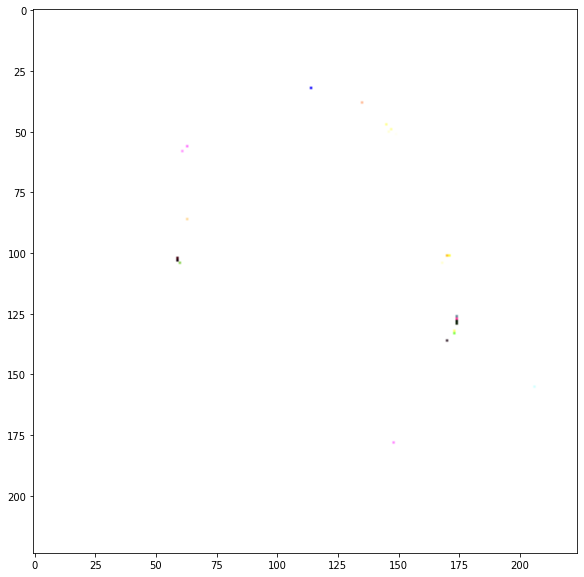

In [120]:
X = g_model.predict(latent_points)
plt.imsave("New_Topo.png",X[1])

# plot the result
plt.figure(figsize=(10,10))
plt.imshow(X[5]*255,cmap="gray")
plt.show()

In [131]:
np.dtype(float)

dtype('float64')